[TOC]

## 1. scipy directed_hausdorff Demo

In [26]:
from scipy.spatial.distance import directed_hausdorff
import numpy as np
u = np.array([(1.0, 0.0),
              (0.0, 1.0),
              (-1.0, 0.0),
              (0.0, -1.0)])
v = np.array([(2.0, 0.0),
              (0.0, 2.0),
              (-2.0, 0.0),
              (-2.0, 0.0),
              (0.0, -4.0)])
max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
x = directed_hausdorff(v, u)
# print(x)

## 2. Geographic Distance

In [27]:
from math import cos, pi, hypot

R = 6371229  # 地球的半径

def get_distance_x(longt1, lat1, longt2, lat2):
    return abs(longt2 - longt1) * pi * R * cos(((lat1 + lat2) / 2) * pi / 180) / 180


def get_distance_y(lat1, lat2):
    return abs(lat2 - lat1) * pi * R / 180


def get_distance(longt1, lat1, longt2, lat2):
    return hypot(get_distance_x(longt1, lat1, longt2, lat2), get_distance_y(lat1, lat2))

# get_distance(116.273342,40.040242,116.301412,39.869666)

In [28]:
from math import floor
import math
def normalize_longitude(d):
    if d == -180.0:
        return -180.0
    else:
        sign = 1 if d > 0 else -1
        x = abs(d) / 360.0
        x2 = (x - floor(x)*1.0) * 360
        if x2 >= 180:
            x2 -= 360
        return x2 * sign


def convert_xy(lon, lat):
    x = lon * pi * R / 180 
    y = lat * pi * R / 180 * cos(lat * pi / 180)
    return x, y

def convert_xy_2(lon, lat):
    x = normalize_longitude(lon)
    y = lat
    return x, y

def coors_tencent_mercator_to_gcj02ll(lng_lat):
    """
    :param: [12970171.73,4851965.33]
    :return: [116.51302944444444,39.90376305555556]
    """
    x = lng_lat[0]
    y = lng_lat[1]
    x = x / 111319.49077777777777777777777778;
    dbl_mercator_lat = y / 111319.49077777777777777777777778;
    y = math.atan(
        math.exp(dbl_mercator_lat * 0.017453292519943295769236907684886)) / 0.0087266462599716478846184538424431 - 90;
    return [x, y]

def coors_gcj02ll_to_tencent_mercator(lng_lat):
    """
    :param: [116.51302944444444,39.90376305555556]
    :return: [12970171.73,4851965.33]
    """
    x = round((lng_lat[0] * 111319.49077777777777777777777778), 2)
    y = math.log(math.tan((90 + lng_lat[1]) * 0.0087266462599716478846184538424431)) / 0.017453292519943295769236907684886
    y = round((y * 111319.49077777777777777777777778), 2)
    return [x, y]


## 3. 使用 directed_hausdorff 来计算两个轨迹之间的相似度

1. 计算相似度，并保存必要的结果的数据
2. 排序 + 可视化
3. 度量

### 尝试用多种相似度比较的方法来实现

In [51]:
import json, sys


def add_to_case_map(route_map, routes_arr, case_type):
    for item in routes_arr:
        route_id = item[1]
        case_id = item[0]
        json_obj = json.loads(item[2])
        route = json_obj['route']
        start_link = json_obj['links'][0]
        end_link = json_obj['links'][-1]
        if route_id not in route_map:
            route_map[route_id] = dict()
        if case_type not in route_map[route_id]:
            route_map[route_id][case_type] = []   
        route_map[route_id][case_type].append([case_id, json_obj['length'], route, start_link, end_link])
    return route_map


file1 = "/Users/andyzhuang/git/andyzhuang/workflow-py/route_compare/ext/data/gaode_normal_route.csv"
file2 = "/Users/andyzhuang/git/andyzhuang/workflow-py/route_compare/ext/data/tencent_normal_route.csv"

routes1 = []
with open(file1, 'r') as f:
    for line in f:
        routes1.append(line.split('\t'))
routes2 = []
with open(file2, 'r') as f:
    for line in f:
        routes2.append(line.split('\t'))

print('len routes1', len(routes1))
print('len routes2', len(routes2))


route_map = dict()
route_map = add_to_case_map(route_map, routes1, "gaode")
route_map = add_to_case_map(route_map, routes2, 'tencent')

print("route_map (case) size: ", len(route_map))

route_compare_result_map = {}

trans_func = coors_gcj02ll_to_tencent_mercator
# trans_func = lambda x: x

# Update

for route_id, case in route_map.items():
    if 'gaode' not in case:
        print('gaode not in case {}'.format(route_id), file=sys.stderr)
        continue
    if 'tencent' not in case:
        print('tencent not in case {}'.format(route_id), file=sys.stderr)
        continue
    a = case['gaode']
    b = case['tencent']

    i = 0
    for case_a in a:
        for case_b in b:
            case_result = {}
            case_result['route_id'] = route_id
            case_result['case_cross_id'] = '{}_{}'.format(route_id, i)
            route_a = case_a[2]
            route_b = case_b[2]
            len_a = case_a[1]
            len_b = case_b[1]
            start_a = case_a[3]
            start_b = case_b[3]
            end_a = case_a[4]
            end_b = case_b[4]
            start_eq = start_a == start_b
            end_eq = end_a == end_b
            u = np.array([trans_func([x[0], x[1]]) for x in route_a])
            v = np.array([trans_func([x[0], x[1]]) for x in route_b])
            dh1 = directed_hausdorff(u, v)
            dh2 = directed_hausdorff(v, u)
            max_dh = max(dh1[0], dh2[0])
            # 异常点
            e = np.array([u[dh1[1]], v[dh1[2]], v[dh2[1]], u[dh2[2]]])
            case_result['e'] = e
            case_result['u'] = u
            case_result['v'] = v
            case_result['dh'] = max_dh
            case_result['len_a'] = len_a
            case_result['len_b'] = len_b
            case_result['start_eq'] = start_eq
            case_result['end_eq'] = end_eq
            case_result['start_a'] = start_a
            case_result['start_b'] = start_b
            case_result['end_a'] = end_a
            case_result['end_b'] = end_b
            case_result['dh_radio'] = max_dh * 2/ (len_a + len_b)
            if route_id not in route_compare_result_map:
                route_compare_result_map[route_id] = []
            route_compare_result_map[route_id].append(case_result)
            i += 1

            
key_func = lambda x: x['dh_radio']            
for k, v in route_compare_result_map.items():
    v.sort(key=key_func)

route_compare_result = [x[0] for k,x in route_compare_result_map.items()]
route_compare_result.sort(key=key_func)

route_compare_score = [(x['case_cross_id'], x['dh'], x['dh_radio'], x['len_a'], x['len_b'], x['start_eq'], x['end_eq']) for x in route_compare_result]

case_id_map = dict()
for k, v in route_compare_result_map.items():
    for item in v:
        case_cross_id = item['case_cross_id']
        case_id_map[case_cross_id] = item
print('route_compare_result_map size:', len(route_compare_result_map))
print('case_id_map size:', len(case_id_map))
print('route_compare_score size:', len(route_compare_score))
for x in route_compare_score:
    print(x)
    
        

len routes1 105
len routes2 326
route_map (case) size:  129
route_compare_result_map size: 78
case_id_map size: 284
route_compare_score size: 78
('5361433123804163216_1', 414.54205697360965, 0.011476483402275951, 36082, 36160, True, False)
('1520636918486565666_1', 370.88776267248744, 0.012215122440881581, 30282, 30444, False, False)
('6803820199946421980_1', 1499.234837276005, 0.012359115272748298, 120453, 122159, False, False)
('9026664459486749998_0', 612.4523116125688, 0.01267925329660519, 48135, 48472, True, False)
('1392964380566766278_0', 695.2764087038948, 0.013581076262174547, 51115, 51274, False, True)
('1064773493442613474_0', 341.0516390505076, 0.013777915811925895, 24683, 24824, True, False)
('3357389272756155582_0', 863.4312404002596, 0.014151826532489668, 60430, 61594, False, False)
('9122739641903710556_4', 530.6421080160458, 0.014546708554793803, 36382, 36575, True, True)
('2554646570221611340_2', 327.1597171114619, 0.015100492354732726, 21515, 21816, True, False)
('82

gaode not in case 6556515480282316796
gaode not in case 968102561266972522
gaode not in case 6843021695351280366
gaode not in case 5195529614023711306
gaode not in case 127773001255562902
gaode not in case 2734698589606000402
gaode not in case 3159486163233606814
gaode not in case 4017062518054484460
gaode not in case 1314012583531835620
gaode not in case 4579382005634531876
gaode not in case 5596048995141579140
gaode not in case 5597024983736719416
gaode not in case 1883943322408371158
gaode not in case 696891612472515070
gaode not in case 8898085228479679622
gaode not in case 5837048519331766904
gaode not in case 4869620875840289464
gaode not in case 3794009209772033068
gaode not in case 6722866699703618822
gaode not in case 5813720839728533790
gaode not in case 119799333568113898
gaode not in case 1976655135190124636
gaode not in case 7124495476812531390
gaode not in case 4571883525414104300
gaode not in case 6724714881701189274
gaode not in case 3290098823784886318
gaode not in cas

### 可视化

<IPython.core.display.Javascript object>


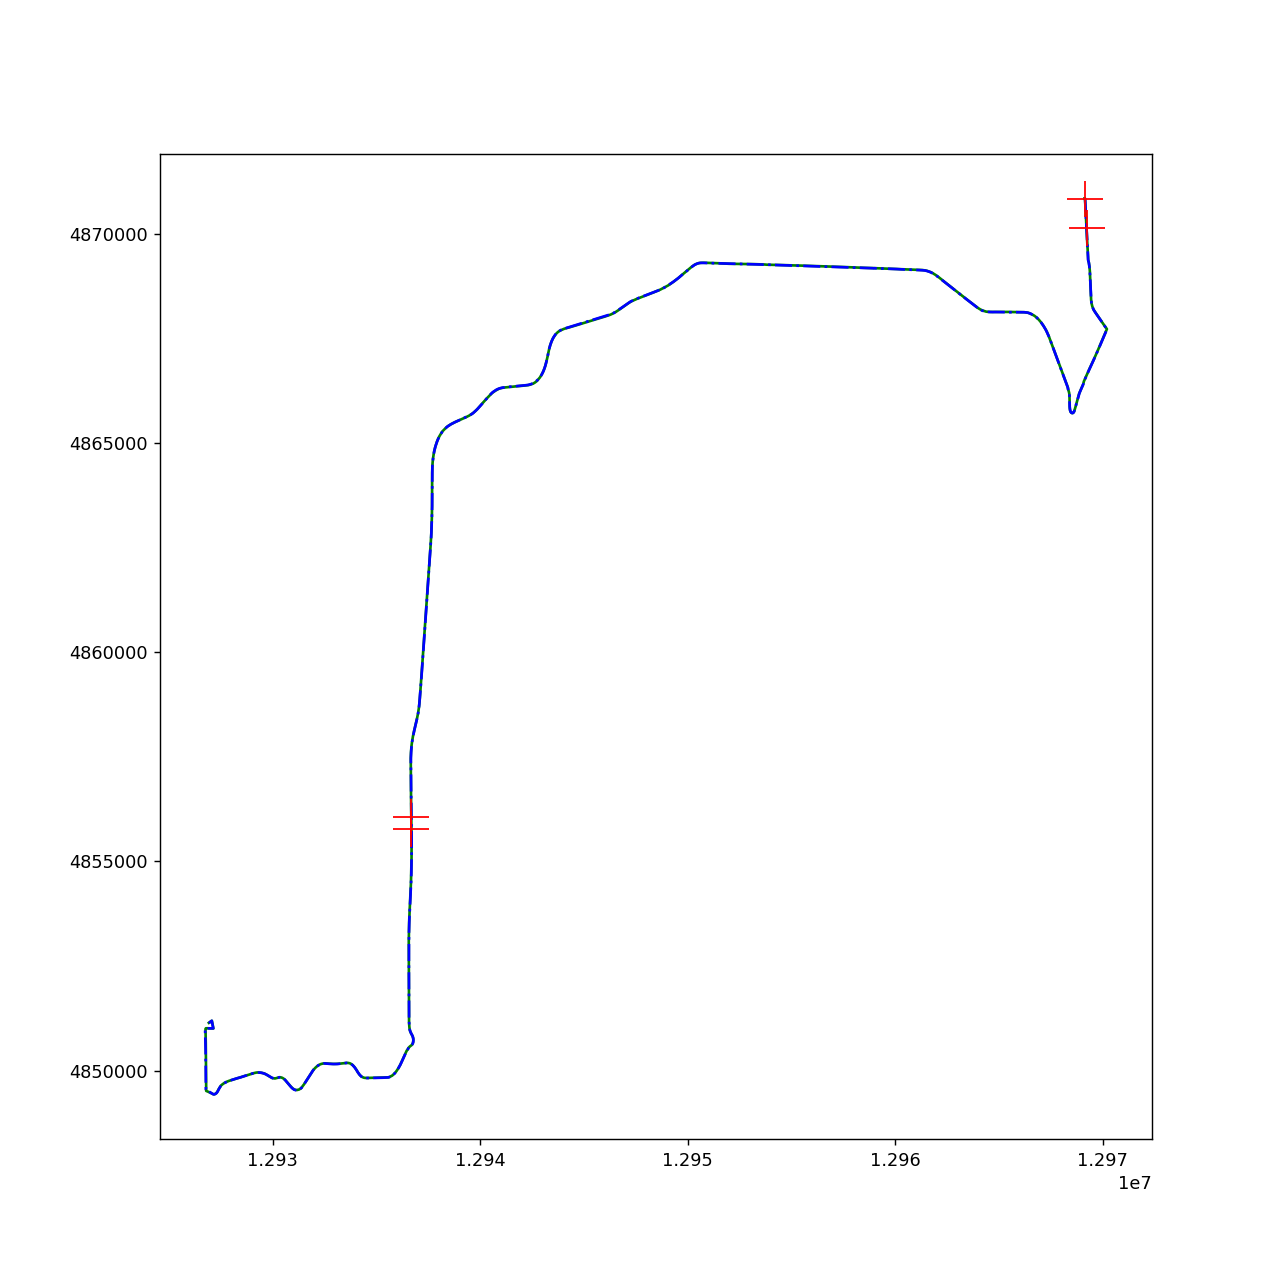

route_id 1392964380566766278
case_cross_id 1392964380566766278_0
dh 695.2764087038948
len_a 51115
len_b 51274
start_eq False
end_eq True
start_a 9100006408820
start_b 9100049875260
end_a 9100032109915
end_b 9100032109915
dh_radio 0.013581076262174547


In [50]:
case_cross_id = '1392964380566766278_0'
case = case_id_map[case_cross_id]
u = case['u']
v = case['v']
e = case['e']

import matplotlib.pyplot as plt
%matplotlib notebook
fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(u[:,0], u[:,1], 'g-', v[:,0], v[:,1], 'b-.', e[:,0], e[:,1], 'r+', markersize=20)
for k,v in case.items():
    if k not in ['u', 'v', 'e']:
        print(k, v)

## matplot 可视化的 demo，尝试性的

(135, 2) (92, 2)
(298.16799710796585, 76, 50) (122.62345982832106, 39, 63)
[[12957520.61  4837347.64]
 [12957222.48  4837342.88]
 [12958216.57  4837661.68]
 [12958094.12  4837655.16]]


<IPython.core.display.Javascript object>


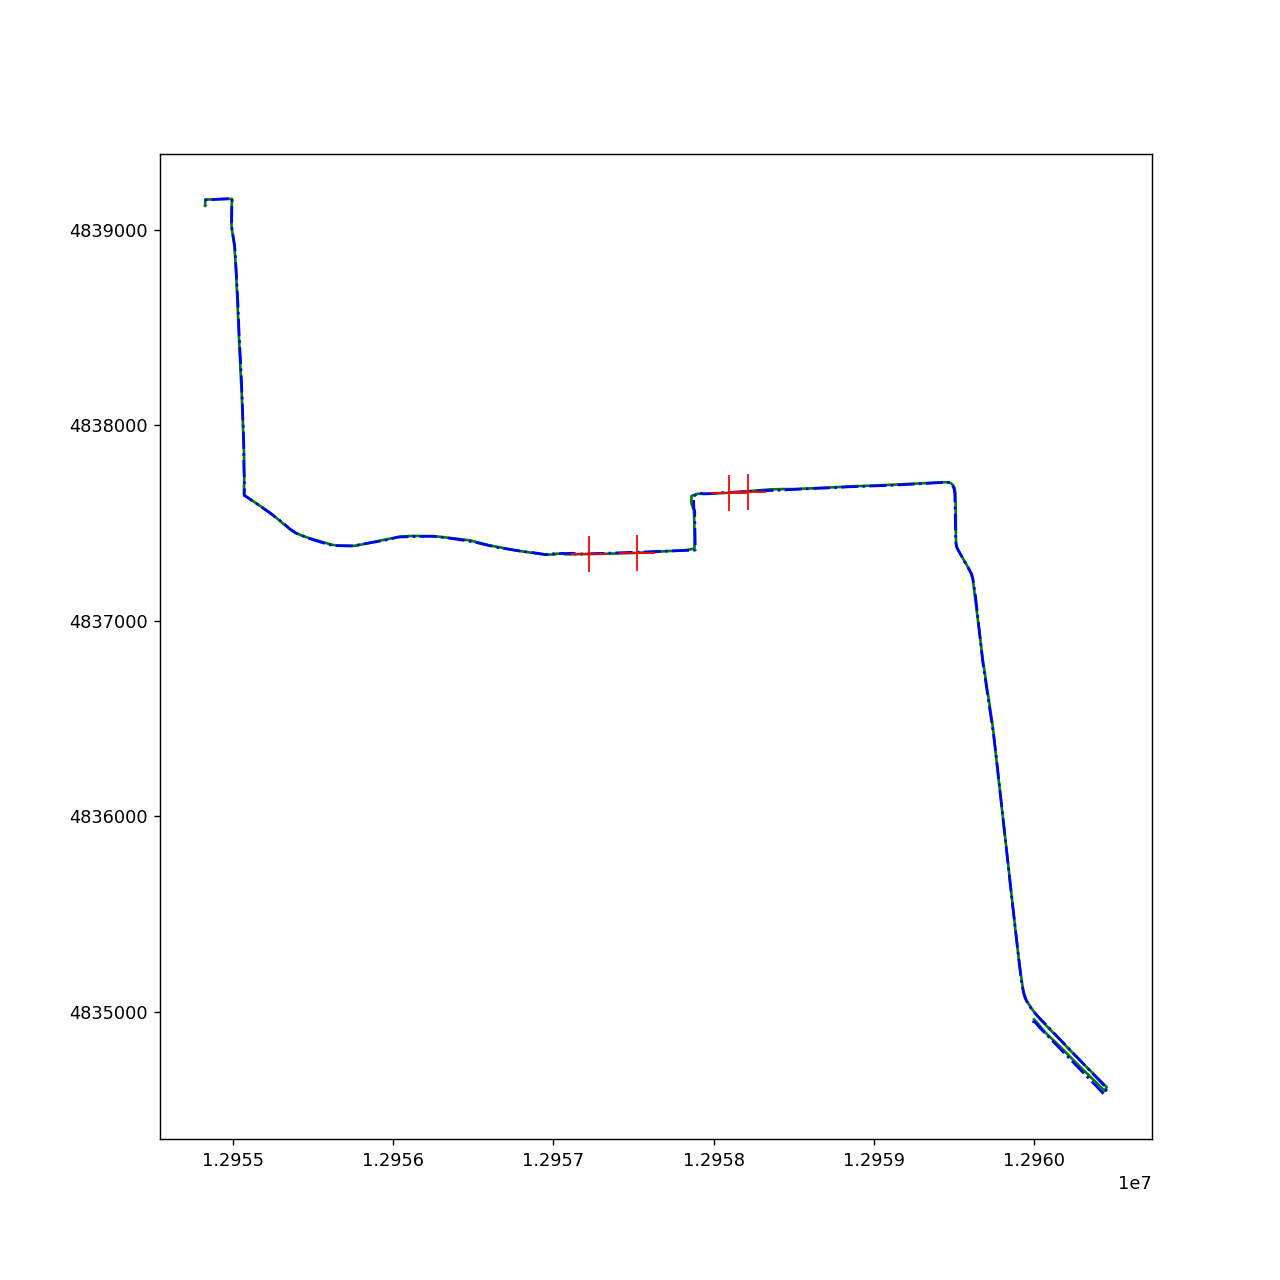

In [37]:
import numpy as np

gaode = [[116.42166666666667, 39.786458333333336], [116.42185333333333, 39.78633694444444], [116.42232194444445, 39.78598083333333], [116.42301638888888, 39.78556416666667], [116.42421, 39.78480916666667], [116.42424055555556, 39.78478722222222], [116.42505222222222, 39.7842925], [116.425625, 39.78393222222222], [116.42573777777778, 39.78407111111111], [116.42573777777778, 39.78407111111111], [116.42433166666666, 39.78495222222222], [116.42194888888889, 39.786501666666666], [116.4216275, 39.78675777777778], [116.42124138888889, 39.78711805555555], [116.42109388888889, 39.78738722222222], [116.42104611111111, 39.78752611111111], [116.42098527777777, 39.78779083333333], [116.42085083333333, 39.788359444444446], [116.42063805555556, 39.78953138888889], [116.420625, 39.789591944444446], [116.42021277777778, 39.79195305555555], [116.42011722222222, 39.792478333333335], [116.42003027777778, 39.79296], [116.41986555555556, 39.79390638888889], [116.41957888888889, 39.79549472222222], [116.41951388888889, 39.79586805555556], [116.41939666666667, 39.7965625], [116.41930555555555, 39.79700527777778], [116.41902777777777, 39.79816833333334], [116.41880638888888, 39.79908861111111], [116.41879777777778, 39.79913194444445], [116.41834638888889, 39.801415], [116.41824222222222, 39.80195305555556], [116.4181988888889, 39.80207472222222], [116.41810777777778, 39.80224833333333], [116.41810777777778, 39.80224833333333], [116.41806, 39.802326388888886], [116.41769111111111, 39.80273], [116.41766055555556, 39.802769166666664], [116.41746083333334, 39.80298166666667], [116.41735666666666, 39.80312055555556], [116.41730472222223, 39.80321611111111], [116.41729611111111, 39.803268333333335], [116.41728305555556, 39.80346361111111], [116.41728305555556, 39.80380638888889], [116.41727861111112, 39.80424055555556], [116.4172525, 39.805065], [116.41720916666667, 39.80522583333333], [116.41717444444444, 39.80527333333333], [116.4171136111111, 39.80534277777778], [116.4171136111111, 39.80534277777778], [116.41701388888889, 39.805395], [116.41685333333334, 39.805438333333335], [116.41652777777777, 39.805438333333335], [116.41450944444445, 39.805373333333335], [116.41254777777777, 39.80531694444444], [116.41162333333334, 39.805299444444444], [116.41122833333333, 39.80528638888889], [116.41113277777778, 39.805282222222225], [116.40934472222222, 39.80522583333333], [116.4080686111111, 39.80519527777778], [116.40751305555555, 39.80519527777778], [116.4068925, 39.805186666666664], [116.40454, 39.805065], [116.40310777777778, 39.80502611111111], [116.4028125, 39.805034722222224], [116.40245666666667, 39.80495222222222], [116.40245666666667, 39.80495222222222], [116.40244361111111, 39.804700555555556], [116.40259555555555, 39.80444444444444], [116.40259972222222, 39.80433166666667], [116.40263027777777, 39.80346361111111], [116.40263027777777, 39.80345055555556], [116.40262166666666, 39.80309472222222], [116.40262166666666, 39.80309472222222], [116.40218305555555, 39.8030425], [116.39938805555556, 39.80294277777778], [116.39772138888888, 39.802912222222226], [116.39537333333334, 39.80289055555556], [116.39529083333333, 39.802912222222226], [116.39485666666667, 39.802912222222226], [116.39478722222222, 39.802881944444444], [116.3941275, 39.80289055555556], [116.39262166666667, 39.80302527777778], [116.39113722222223, 39.8032075], [116.39055111111111, 39.80330305555555], [116.39002611111111, 39.80338555555556], [116.38915805555555, 39.803455], [116.38900166666667, 39.80346361111111], [116.38802083333333, 39.803533055555555], [116.38678833333333, 39.80354166666667], [116.38616333333333, 39.80352], [116.38571611111111, 39.80346361111111], [116.38529944444444, 39.80341583333333], [116.383685, 39.80320305555556], [116.38336805555555, 39.80318583333333], [116.38290361111112, 39.80319], [116.38266055555556, 39.80319444444444], [116.38227, 39.80323361111111], [116.38120666666667, 39.80342888888889], [116.38102444444445, 39.80346361111111], [116.38099833333334, 39.803467777777776], [116.38059027777778, 39.803559166666666], [116.38026055555555, 39.803645833333334], [116.38010861111111, 39.80370222222222], [116.379935, 39.803780277777776], [116.37904083333333, 39.80425361111111], [116.378815, 39.80436638888889], [116.37736111111111, 39.80499138888889], [116.37736111111111, 39.80499138888889], [116.37736555555556, 39.805277777777775], [116.37738277777778, 39.805638055555555], [116.37737416666667, 39.80603305555555], [116.37736555555556, 39.80644111111111], [116.37722666666667, 39.808728333333335], [116.37719194444445, 39.80908], [116.37719194444445, 39.80908], [116.377105, 39.81023861111111], [116.37701833333334, 39.811484444444446], [116.37700944444444, 39.81162333333333], [116.37700083333333, 39.81175361111111], [116.37694888888889, 39.812486944444444], [116.37692277777778, 39.81281694444444], [116.37683166666666, 39.81375], [116.37674916666667, 39.81411888888889], [116.37667972222222, 39.81439666666667], [116.37667527777778, 39.81445305555555], [116.37665805555555, 39.81455722222222], [116.37665805555555, 39.81501305555555], [116.37668416666666, 39.815351666666665], [116.37669277777778, 39.815446944444446], [116.37669277777778, 39.815446944444446], [116.37519527777778, 39.815421111111114], [116.37519527777778, 39.815421111111114], [116.37518222222222, 39.815199722222225]]
tencent = [[116.42156903027394, 39.78637870184693], [116.42170997594204, 39.78637000409768], [116.42196860091235, 39.78617444250881], [116.42559995061738, 39.78380998781188], [116.42559995061738, 39.78380998781188], [116.42574996926984, 39.78401998383541], [116.42160999345089, 39.7867499428493], [116.42151998225941, 39.78681993860408], [116.42133995987646, 39.78700997602894], [116.421189941224, 39.787179994536984], [116.42112993376301, 39.78727994838053], [116.42107001613356, 39.78742994790227], [116.42093994008039, 39.78787994450522], [116.4203436383947, 39.79116098584831], [116.41958995187122, 39.79548995664189], [116.41939995818859, 39.79649999682121], [116.41879000211058, 39.79907996993447], [116.41838001101485, 39.80142995885379], [116.41823996366205, 39.80201996254891], [116.41816998490141, 39.802189874944645], [116.41788000872766, 39.80251996756613], [116.41764995018337, 39.80274998935715], [116.41758994272239, 39.80283998267171], [116.41739410999041, 39.80305419941297], [116.41731999897947, 39.80314998941509], [116.41726996281812, 39.80333998172617], [116.41725999151848, 39.803775864754016], [116.41721992665678, 39.80501000052439], [116.41719001275783, 39.80517997454248], [116.4170799691355, 39.80534994814033], [116.41700936155416, 39.80540467361453], [116.41689994675255, 39.805430000521625], [116.4162699582437, 39.80541992496842], [116.41370993934666, 39.80532993503047], [116.41116079006456, 39.80527217302205], [116.41066995059325, 39.805249951543516], [116.40935993741424, 39.80522000084372], [116.40717999571396, 39.80514995480124], [116.40600994005622, 39.80512994163314], [116.40564001382218, 39.80510999747017], [116.4044299831343, 39.8050799776984], [116.40342000726024, 39.80502994471635], [116.40312994125496, 39.80502994471635], [116.40287994011135, 39.80505996450998], [116.40287994011135, 39.80505996450998], [116.40256993150676, 39.80493995426798], [116.4025905927583, 39.8045087023942], [116.40263739498462, 39.804425198358274], [116.40267000382944, 39.803039982729814], [116.40267000382944, 39.803039982729814], [116.39670995141306, 39.80290989304112], [116.39595994798225, 39.802899955144966], [116.39586993679077, 39.80292997586855], [116.39447997355146, 39.80290989304109], [116.39439993365963, 39.802879941321976], [116.39432995489899, 39.802879941321976], [116.39359998389902, 39.80294998967699], [116.39304994545047, 39.8029899482633], [116.39152999598953, 39.8031399825407], [116.39022995411017, 39.80332997487946], [116.38983999544527, 39.80337000225765], [116.38856995729641, 39.80348994622727], [116.38788993262624, 39.803529973512326], [116.38600598581212, 39.80350298960374], [116.38528993869903, 39.803389946925336], [116.38374106348594, 39.8032212797263], [116.38357999555548, 39.80318994788516], [116.38245000475943, 39.80319995475227], [116.38208034801997, 39.803240603321626], [116.38120997034106, 39.80340996059985], [116.38033995198828, 39.803619896793634], [116.37995358658452, 39.80378207586017], [116.37946993363548, 39.80403997429431], [116.3787999700965, 39.80435998232579], [116.37802993423483, 39.80469993315563], [116.37738000312669, 39.80496990508979], [116.37738000312669, 39.80496990508979], [116.37738997442634, 39.80536989223373], [116.3773519756898, 39.80600968739785], [116.37734999939617, 39.806849879640936], [116.37721965384843, 39.80909919798452], [116.3770899371214, 39.81068999680514], [116.37702543808399, 39.81173183173743], [116.37685996840862, 39.813659992063464], [116.37682996467814, 39.81383988101203], [116.37669000715685, 39.81434994331883], [116.37666997472601, 39.81453997368129], [116.37669449873327, 39.81546396640502], [116.37669449873327, 39.81546396640502], [116.37520994289453, 39.81540993894447], [116.37520994289453, 39.81540993894447], [116.37523213128206, 39.81520424780254]]

u = np.array([coors_gcj02ll_to_tencent_mercator([x[0], x[1]]) for x in gaode])
v = np.array([coors_gcj02ll_to_tencent_mercator([x[0], x[1]]) for x in tencent])
print(u.shape, v.shape)

dh1 = directed_hausdorff(u, v)
dh2 = directed_hausdorff(v, u)
# print(u)
x = max(dh1[0], dh2[0])
# x = directed_hausdorff(v, u)
print(dh1, dh2)

# 异常点
e = np.array([u[dh1[1]], v[dh1[2]], v[dh2[1]], u[dh2[2]]])
print(e)

import matplotlib.pyplot as plt
%matplotlib notebook
fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(u[:,0], u[:,1], 'g-', v[:,0], v[:,1], 'b-.', e[:,0], e[:,1], 'r+', markersize=20)

## 笔记

* direct_hausdorff 如果两组数据，疏密程度不同，是否有很大影响

不需要精确的计算距离，所以都转化成投影的墨卡托坐标系，墨卡托坐标，计算空间几何的距离